In [22]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA
from __future__ import print_function
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression

sns.set()

In [23]:
# Import databases
df_pitchfork_spotify = pd.read_pickle('df_pitchfork_spotify2.pkl')
df_pitchfork = pd.read_pickle('df_pitchfork.pkl')
df_authors_reviews = pd.read_pickle('df_authors_reviews.pkl')
df_features = pd.read_pickle('df_features.pkl')
df_kmeans = pd.read_pickle('df_kmeans.pkl')

# 1. Perform cluster EDA

After completing clustering mini-project, we apply the methods here to determine whether there are better initial approaches to clustering the data.

>### 1.1 Elbow method

In [24]:
# Function that applies scikit-learn KMeans clustering to 
def clustering(k): # k = # of clusters
    model = KMeans(n_clusters=k)
    clusters = model.fit_predict(df_matrix)
    inertia = model.inertia_
    return model, clusters, inertia

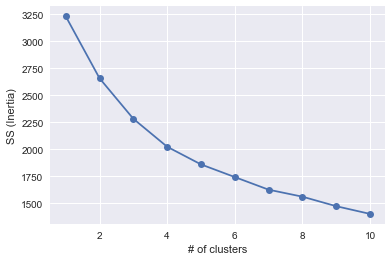

In [25]:
df_matrix = df_kmeans
df_matrix = df_matrix[np.isfinite(df_matrix['acousticness'])] # remove NaN's

ks = range(1,11)
inertias = []

for k in ks:
    model, clusters, inertia = clustering(k)
    inertias.append(inertia)
    
plt.plot(ks, inertias, '-o');
plt.ylabel('SS (Inertia)');
plt.xlabel('# of clusters');

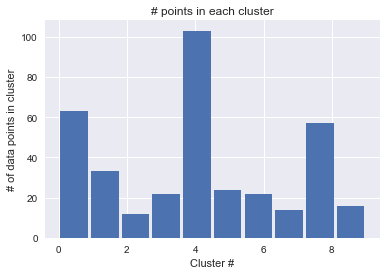

In [26]:
plt.hist(clusters, rwidth=0.9);
plt.xlabel('Cluster #');
plt.ylabel('# of data points in cluster');
plt.title('# points in each cluster');

>### 1.2 Silhouette score

For n_clusters = 2 The average silhouette_score is : 0.19260388869518405


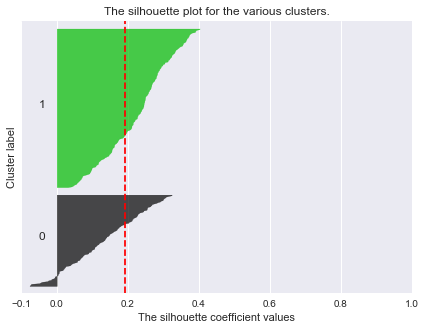

For n_clusters = 3 The average silhouette_score is : 0.17851453242149268


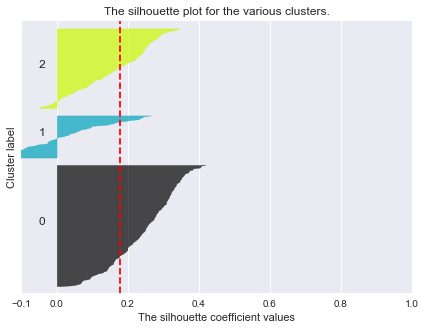

For n_clusters = 4 The average silhouette_score is : 0.17481284824768317


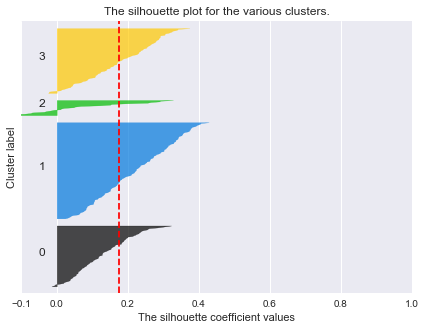

For n_clusters = 5 The average silhouette_score is : 0.16235761091387815


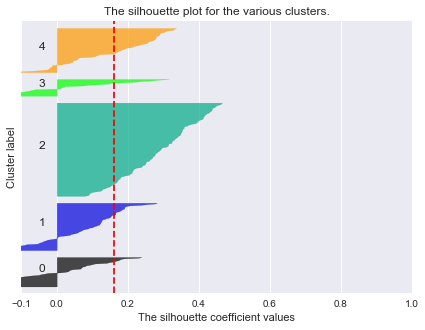

For n_clusters = 6 The average silhouette_score is : 0.15343462571461017


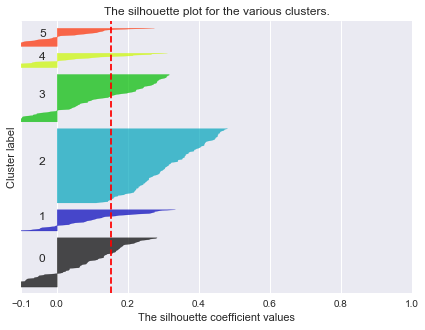

For n_clusters = 7 The average silhouette_score is : 0.17095885749562323


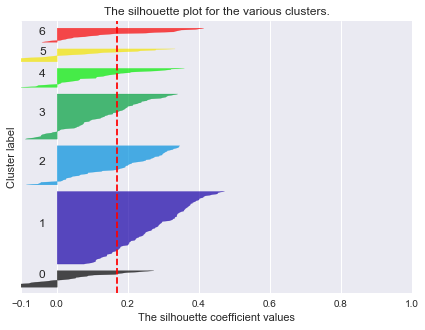

For n_clusters = 8 The average silhouette_score is : 0.15978009541828814


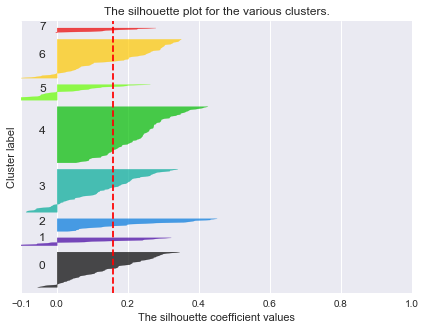

For n_clusters = 9 The average silhouette_score is : 0.15856459574904114


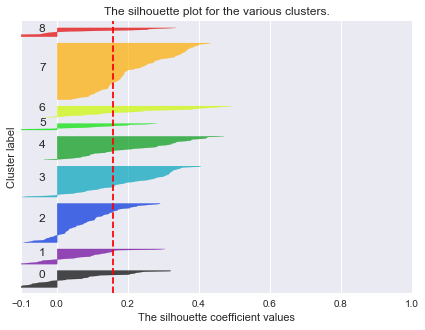

For n_clusters = 10 The average silhouette_score is : 0.1701231890541888


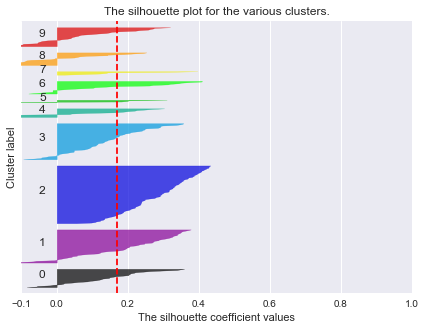

In [27]:
range_n_clusters = range(2,11)
X = pd.DataFrame.copy(df_matrix) # recall df_matrix is just the matrix of feature values fed into clustering algorithm; duplicated as "X" here to prevent changes to this original feature matrix
silhouette_avg_all = []

for n_clusters in range_n_clusters:
    
    fig, ax1 = plt.subplots(1,1)
    fig.set_size_inches(7, 5)

    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10]) # Insert blank space between plots of individual clusters to demarcate them
    
    # Perform clustering
    model = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = model.fit_predict(X)

    # Silhouette score
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_avg_all.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.");
    ax1.set_xlabel("The silhouette coefficient values");
    ax1.set_ylabel("Cluster label");

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    plt.show()

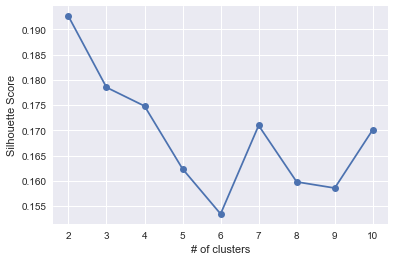

In [28]:
plt.plot(range(2,11), silhouette_avg_all, '-o');
plt.ylabel('Silhouette Score');
plt.xlabel('# of clusters');

<b>Summary</b>: Elbow & silhouette methods suggest perhaps using # clusters = 4. We proceed with PCA, using this # of clusters.

>### 1.3 PCA

### 1.3.1 Perform PCA

In [95]:
# Set n_clusters from silhouette scoring
k = 3
model, clusters, inertia = clustering(k)

# Perform PCA
pca = PCA(n_components=2)

# Combine PCA info onto dataframe (df_matrix)
pca_cluster = pd.DataFrame.copy(df_matrix)
pca_cluster.loc[:,'x'] = pca.fit_transform(df_matrix)[:,0]
pca_cluster.loc[:,'y'] = pca.fit_transform(df_matrix)[:,1]
pca_cluster.loc[:,'cluster'] = clusters

pca_cluster.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,x,y,cluster
author_fullname,,,,,,,,,,,,,,,,
aaron leitko,1.7669613509,2.7102818648,0.4394045530,4.7816769157,3.6834826070,3.4459148373,1.3192222425,5.6089777642,5.1194929396,0.3194623449,3.4331326740,5.0673484630,2.7936581369,-1.0384302085,1.6040226711,1
abigail covington,1.4951118364,4.5360173469,0.3154418588,4.3567193344,0.0626842169,3.6649783550,1.3568244620,5.7701599203,3.6304761905,1.4365050169,2.8159083971,5.0975000000,3.6847003832,1.7947596062,-1.6199340494,0
abigail garnett,1.1352992396,5.0830765529,0.4835500103,4.8579345464,4.7580254769,3.5848963663,0.7246622576,5.4236931736,4.3652669553,0.2864009163,3.3340825946,5.1674801587,3.7536733442,-0.2373350929,2.4524742378,1
adam dlugacz,0.0012127985,2.0102734596,0.2351180050,5.2985298573,0.4313224214,2.4230769231,2.0638801090,5.4037899891,4.8461538462,0.1949768670,3.6321965228,4.7250000000,2.5469475417,0.3343474623,-1.0358457196,2
adam moerder,1.2598394617,2.8502051162,0.2772205694,4.2148253480,1.5645504890,2.9592236849,0.9925679705,4.9584907427,4.1454142274,0.2929232154,3.0295720821,4.3788213460,2.8272613591,-0.6266300417,-0.9822024690,2


#### Plot principal components

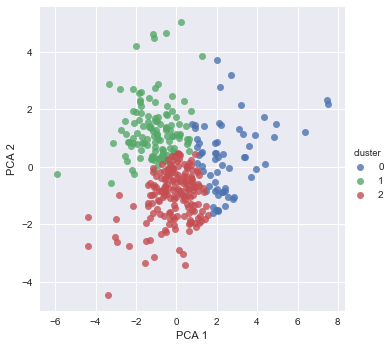

In [96]:
g = sns.lmplot(x='x', y='y', data=pca_cluster, fit_reg=False, hue='cluster');
g.set(xlabel='PCA 1', ylabel='PCA 2');

There is clear separation between the three clusters under PCA. We proceed with interpreting the characteristics of each principal component.

#### Examine characteristics of each principal component

In [31]:
pca_cluster.groupby('cluster').mean()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,x,y
cluster,,,,,,,,,,,,,,,
0,1.8609526632,3.3817996174,0.4375719666,4.6171866546,3.7277640520,3.4785554225,1.2342825954,5.5863068681,4.6079425938,0.4662593010,3.3351579387,5.1339886306,2.6992844645,-0.9752647319,1.4469009570
1,3.0951877408,3.3294585653,0.3571155602,3.3548711351,1.9180982607,3.1893526643,1.0263592117,5.1685655075,4.8558698578,0.3439303645,2.9363182792,4.8426946853,2.5738356987,-0.8678231558,-0.6862571832
2,1.4753287367,3.8415977045,0.3095006511,4.5091267302,1.1291182010,3.2327432834,1.2150540781,5.4404684863,4.1824302558,0.7406685684,3.1018340615,4.9205954461,3.2702378432,0.6606972478,-0.8064718369
3,2.1101664791,5.2260612213,0.4372734976,5.3104275926,1.0894147378,4.0972494034,1.8138420250,6.5476960673,6.1968749667,0.6157432396,4.0587716842,6.2008376620,5.3592029669,3.7246260617,1.2517585650


It's difficult to say what the suite of features are that set apart the three PCA components. Regardless, we proceed with performing linear regression modelling on each component to determine if these components are useful for generating clusters whose linreg models can predict critic ratings.

### 1.3.2 How well do PCA clusters perform in linear regression?

#### Set up some functions

Used not only for PCA, but for the clustering, linear regression, and cross validation pipeline later.

- <b>`cluster_reviews` return reviewids of all critics belonging to the cluster.</b> Requires a specific dataframe, <b><i>df_cluster</b></i>, which is indexed by critic, consists of the features matrix and an additional column to specify each critic's cluster assignment. The PCA's <b><i>df_cluster</b></i> dataframe is generated below:

In [32]:
# Generate df_cluster dataframe from PCA clusters
df_cluster = pd.DataFrame.copy(df_matrix)
df_cluster['cluster'] = clusters
df_cluster.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,cluster
author_fullname,,,,,,,,,,,,,,
aaron leitko,1.7669613509,2.7102818648,0.4394045530,4.7816769157,3.6834826070,3.4459148373,1.3192222425,5.6089777642,5.1194929396,0.3194623449,3.4331326740,5.0673484630,2.7936581369,0
abigail covington,1.4951118364,4.5360173469,0.3154418588,4.3567193344,0.0626842169,3.6649783550,1.3568244620,5.7701599203,3.6304761905,1.4365050169,2.8159083971,5.0975000000,3.6847003832,2
abigail garnett,1.1352992396,5.0830765529,0.4835500103,4.8579345464,4.7580254769,3.5848963663,0.7246622576,5.4236931736,4.3652669553,0.2864009163,3.3340825946,5.1674801587,3.7536733442,0
adam dlugacz,0.0012127985,2.0102734596,0.2351180050,5.2985298573,0.4313224214,2.4230769231,2.0638801090,5.4037899891,4.8461538462,0.1949768670,3.6321965228,4.7250000000,2.5469475417,2
adam moerder,1.2598394617,2.8502051162,0.2772205694,4.2148253480,1.5645504890,2.9592236849,0.9925679705,4.9584907427,4.1454142274,0.2929232154,3.0295720821,4.3788213460,2.8272613591,2


In [33]:
def cluster_reviews(cluster_num, df): # df_cluster = dataframe w/ features & cluster assignment in column 'cluster', index = author
    
    df2 = df[df['cluster']==cluster_num]
    authors = df2.index
    
    reviewids = []
    for a in authors:
        reviews = df_authors_reviews[df_authors_reviews['author_fullname']==a]['reviews']
        reviews = list(reviews)[0]
        reviewids.extend(reviews)
        
    return reviewids

- <b>`cluster_examine` trains a linear regression model for <i>each</i> cluster.</b> Take each cluster, train a linear regression model for critics in that cluster. The model uses weighted features (album features weighted by critic's rating) as predictors for actual album rating awarded by critics.

In [34]:
def cluster_examine(cluster_num, features, df): # features must be a list
    
    # extract reviews belonging to cluster
    reviewids = cluster_reviews(cluster_num, df) # list of all reviews belonging to cluster  
    df2 = df_features[df_features['reviewid'].isin(reviewids)] # features of all these reviews
    size = len(df2)
    
    # extract authors belonging to cluster
    df3 = df_pitchfork[df_pitchfork['reviewid'].isin(reviewids)]
    author = df3['author'].unique()
    
    # set features we want in model
    X_func = df2[features]
    
    # train model
    y_func = df2['score'].values.reshape((len(df2),1))
    X_train, X_test, y_train, y_test = train_test_split(X_func, y_func, test_size=0.3, random_state=101)
    lm = LinearRegression() # create linear model object
    model = lm.fit(X_train, y_train) # fit linear regression model to data
    score = model.score(X_test, y_test)
    pd.set_option('display.precision',10)
    cdf = pd.DataFrame(lm.coef_[0], X_func.columns, columns=['Coeff']) # table of parameter coefficients
    
    # save indicies of train and test sets

    # generate predictions for test set, based on the model we just generated above
    prediction = lm.predict(X_test)
    
    # scipy linregress
    slope, intercept, r_value, p_value, std_err = stats.linregress(y_test[:,0], prediction[:,0])
    
    return cdf, X_train, X_test, y_train, y_test, prediction, slope, r_value, p_value, size, author, score, model

- <b>`cluster_linreg` generate linear regression models for <i>all</i> clusters.</b> Uses the above `cluster_examine` function to generate a linear regression model for <i>all</i> clusters resulting from a clustering algorithm. The resulting stats can be used to compare different clusters side-by-side.

In [35]:
# n_clusters = number of clusters
# X = feature matrix
# features = desired audio features in linreg model

def cluster_linreg(n_clusters, X, features, df):    

    cdfs=[]; y_tests=[]; predictions=[]; slopes=[]; r_values=[]; p_values=[]; \
    sizes=[]; authors=[]; size_authors=[]; scores=[]; models=[]; train_idxs=[]; test_idxs=[];
    
    for cluster_num in range(n_clusters):
        
        if len(df[df['cluster']==cluster_num]) < 5:
            continue
            
        # fit linear model
        cdf, X_train, X_test, y_train, y_test, prediction, slope, r_value, p_value, size, author, score, model = \
        cluster_examine(cluster_num, features, df=df)
        
        # store results
        cdfs.append(cdf)
        y_tests.append(y_test)
        predictions.append(prediction)
        slopes.append(slope)
        r_values.append(r_value)
        p_values.append(p_value)
        sizes.append(size)
        authors.append(author)
        size_authors.append(len(author))
        models.append(model)
        scores.append(score)
        train_idxs.append(X_train.index.tolist())
        test_idxs.append(X_test.index.tolist())
    
    return cdfs, y_tests, predictions, slopes, r_values, p_values, sizes, authors, size_authors, scores, models, train_idxs, test_idxs

#### Compile info on each cluster

In [36]:
features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 
                'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 
                'valence', 'popularity']

df_func = pd.DataFrame.copy(df_cluster)

cdfs, y_tests, predictions, slopes, r_values, p_values, sizes, authors, size_authors, scores, models, train_idxs, test_idxs = \
cluster_linreg(n_clusters=k, X=X, features=features, df=df_func)

In [37]:
# produce table of a few selected stats (pval, r, cluster size, slope)
pd.DataFrame({'slopes':slopes, 'r_values': r_values, 'p_values':p_values, 'size_reviews':sizes, 
              'size_authors':size_authors, 'cv_score':scores})

,cv_score,p_values,r_values,size_authors,size_reviews,slopes
0,0.0660935279,1.8744811926e-21,0.2575213021,104,4401,0.0667651721
1,0.0465841738,1.1104998406e-12,0.2158344502,95,3544,0.0466868506
2,0.0225094488,8.1059159561e-11,0.1621763668,143,5289,0.0292789509
3,0.4146970321,1.1172153362e-04,0.6559992246,24,95,0.4324890645


### 1.3.3 Summary
Based on the low r-values, the clusters don't yield good linear regression models (to predict critic ratings). So we proceed with testing other methods for generating clusters.

>### 1.4 Other clustering algorithms

Since PCA performed poorly when generating clusters for linear regression, we try other clustering algorithms.

### 1.4.1 Silhouette scores

#### Affinity propogation

In [17]:
from sklearn.cluster import AffinityPropagation
from sklearn import cluster

X = pd.DataFrame.copy(df_matrix)

af = AffinityPropagation().fit(X)
cluster_centers_indices = af.cluster_centers_indices_

labels_af = af.labels_

#print('Estimated number of clusters: %d' % n_clusters_)
print('Average silhouette_score:', silhouette_score(X, labels_af))

Average silhouette_score: 0.10679604704138726


#### Spectral clustering

In [18]:
spec = cluster.SpectralClustering(n_clusters=5)
spec.fit(X)

labels_spec = spec.labels_

print('Average silhouette_score:', silhouette_score(X, labels_spec))

Average silhouette_score: -0.17307529392989118


#### Agglomerative clustering

In [19]:
agglo = cluster.AgglomerativeClustering(n_clusters=5)
agglo.fit(X)

labels_agglo = agglo.labels_

print('Average silhouette_score:', silhouette_score(X, labels_agglo))

Average silhouette_score: 0.10522049997344707


#### DBSCAN

In [20]:
dbscan = cluster.DBSCAN(eps=0.3, min_samples=10)

dbscan.fit(X)

labels_dbscan = dbscan.labels_

#print('Average silhouette_score:', silhouette_score(X, labels_dbscan))
print('Average silhouette_score: no score, since only 1 cluster generated')

Average silhouette_score: no score, since only 1 cluster generated


### 1.4.2 Summary
None of these methods yield particularly good silhouette scores, so we continue with our original KMeans algorithm.

# 2. Pick best-performing clusters using KMeans

#### Set criteria for selecting good-performing clusters

Recall criteria set for "best performing" clusters in data_EDA notebook.

In [71]:
limit_size_reviews = 10
limit_size_authors = 6
limit_r_values = 0.5
limit_slope = 0.5
limit_pvalue = 0.05

#features = ['acousticness', 'danceability', 'duration_ms', 'energy', 'instrumentalness', 
#                'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 
#                'valence', 'popularity']

features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                'liveness', 'loudness', 'speechiness', 'tempo', 'mode',
                'valence']

#### Perform KMeans iteratively

To pick best clusters and compile. Result is dataframe, `df_bestclusters`, a compilation of all the best-performing clusters found during iterative KMeans performed below.

<i>df_bestclusters columns</i>:
- <b>author</b>: list of critics belonging to the cluster
- <b>p_value</b>: p-value of linear regression on training set of the cluster's critics
- <b>prediction</b>: list of predicted album ratings
- <b>r_value</b>: Pearson's R of linear regression on training set of the cluster's critics
- <b>score</b>: sklearn's cross-validation score: $$ R^2 = 1 - \frac{RSS}{TSS} $$

    - $R^2$ = proportion of variability in $Y$ that is explained by $X$ using our model. 
    - $RSS$ (residual sum of squares) = variability left unexplained after performing the regression. 
    - $TSS$ = total variance in $Y$.
    <p>
- <b>size_authors</b>: number of critics in the cluster
- <b>size_review</b>: number of reviews in the cluster
- <b>slope</b>: slope of the linear regression
- <b>test_idx</b>: convenient list of df_features index lookup of the test set
- <b>train_idx</b>: same as above, but for training set

In [73]:
df_bestclusters = pd.DataFrame()
X_iter = pd.DataFrame.copy(X)

for random_state in range(0,10000): # try range of random states
    
    for n_clusters in range(9,13): # try a range of # of clusters
        # KMeans
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state).fit(X_iter)
        labels = kmeans.labels_
        df_cluster = pd.DataFrame.copy(X_iter)
        df_cluster['cluster'] = labels

        # Linear regression on each cluster
        cdfs, y_tests, predictions, slopes, r_values, p_values, sizes, authors, size_authors, scores, models, train_idxs, test_idxs \
        = cluster_linreg(n_clusters=n_clusters, X=X, features=features, df=df_cluster)

        # Combine data into temporary dataframe
        df = pd.DataFrame({'slope':slopes, 'r_value': r_values, 'p_value':p_values, 'size_review':sizes, 
                           'size_author':size_authors, 'score':scores, 'test_idx':test_idxs, 
                           'train_idx':train_idxs, 'author':authors, 'prediction':predictions})

        for idx, cluster in df.iterrows():

            if cluster['r_value'] < limit_r_values:
                continue
            if cluster['slope'] < limit_slope:
                continue
            if cluster['size_author'] < limit_size_authors:
                continue
            if cluster['p_value'] > limit_pvalue:
                continue
                
            cluster = df.iloc[idx]

            X_iter = X_iter.drop(index=cluster['author'].tolist()) # accept cluster & remove its authors from next KMeans iteration to avoid resampling
            if df_bestclusters.empty is True:
                df_bestclusters = pd.DataFrame(columns=cluster.index.tolist())

            df_bestclusters = df_bestclusters.append(cluster)

            if len(X_iter) < 10:
                break

df_bestclusters = df_bestclusters.reset_index()
df_bestclusters

,index,author,p_value,prediction,r_value,score,size_author,size_review,slope,test_idx,train_idx
0,6,"[quinn moreland, caryn rose, simon reynolds, c...",0.0400552471,"[[9.232810052306798], [8.078551950842261], [7....",0.6890869497,-1.1312628986,10,28,1.2531056459,"[8796, 12859, 484, 1055, 103, 13254, 11048, 11...","[11024, 198, 87, 13297, 782, 211, 925, 19, 110..."
1,1,"[jesse jarnow, jonathan bernstein, stephen erl...",0.0293904384,"[[8.387407115000581], [9.422195806433326], [8....",0.6833075610,0.3808707832,12,33,0.6466791530,"[667, 206, 1014, 11236, 1150, 1321, 1222, 1715...","[10368, 717, 632, 295, 114, 82, 1075, 396, 164..."
2,1,"[saby kulkarni, christopher randle, estelle ta...",0.0038796297,"[[7.230327040445464], [7.868636079199502], [6....",0.8479175474,0.1174417951,10,27,1.1099557493,"[13314, 11520, 13031, 3213, 1721, 3154, 793, 1...","[278, 3037, 7152, 122, 2777, 2007, 1391, 3097,..."
3,10,"[simon goddard, erin macleod, alan light, mari...",0.0198622082,"[[9.065199174793788], [7.441271151462729], [6....",0.6344021203,-0.1994572637,7,41,0.7443422972,"[6787, 6690, 8185, 7372, 7489, 7884, 6789, 279...","[4230, 460, 7995, 7691, 7338, 366, 8013, 6571,..."
4,10,"[robert ham, sarah sahim, b zarley, melody lau...",0.0074017292,"[[8.689370675308263], [7.4745284115369355], [2...",0.7829563133,0.4019326499,11,32,0.9659156030,"[9879, 13195, 13152, 12144, 11482, 12068, 1020...","[11306, 11038, 1076, 962, 11497, 13019, 11076,..."
5,2,"[daniel martin-mccormick, marcus dowling, matt...",0.0452460423,"[[6.3060613039010915], [5.763105260361554], [7...",0.6422584030,0.2660835400,8,32,0.6036250998,"[680, 2299, 2245, 2138, 1858, 2076, 239, 2205,...","[1841, 1383, 395, 133, 2041, 2211, 1440, 598, ..."
6,5,"[alexander iadarola, piotr orlov, judy berman,...",0.0308069569,"[[-6.453144358381564], [13.840263908056329], [...",0.8530447498,-477.7271680022,9,17,17.2656650503,"[562, 2566, 11197, 285, 166, 4640]","[2413, 1245, 1920, 849, 1616, 1762, 11351, 152..."
7,8,"[timmhotep aku, andy emitt, rob harvilla, bob ...",0.0025382954,"[[9.408836443690783], [5.451248952338341], [6....",0.8659892970,0.1312808406,9,29,1.2948333064,"[12817, 12912, 8677, 13228, 1135, 13224, 12868...","[12740, 4793, 857, 12808, 12828, 11954, 7320, ..."
8,10,"[claire lobenfeld, eric torres, maud deitch, r...",0.0247889247,"[[8.08017228945862], [6.556536303382827], [5.6...",0.5576938633,-0.4690495939,13,53,0.6512304627,"[2601, 1141, 11301, 11440, 8187, 7911, 2210, 2...","[13134, 1655, 1419, 8113, 11481, 8115, 2115, 7..."
9,5,"[dorian lynskey, kris ex, daphne brooks, jeff ...",0.0344097213,"[[8.78838078114184], [8.019923194010493], [8.5...",0.6689664227,0.1022623106,7,31,0.7233820774,"[663, 13202, 13199, 4780, 3981, 4557, 268, 485...","[3799, 743, 406, 102, 4262, 5533, 871, 458, 11..."


#### Plot individual cluster performance: actual vs. predicted ratings (linear regression model)

Examine linear regression model performance on individual cluster.

In [81]:
def cluster_plot(cluster_num, df): # features must be a list
    
    # access test data
    idx = df['test_idx'].iloc[cluster_num]
    y_test = df_features.iloc[idx]['score']
    prediction = df['prediction'].iloc[cluster_num]
    
    # plot
    g = sns.jointplot(y_test.values, prediction[:,0], kind='reg', color='orange',
                      joint_kws={'line_kws':{'color':'yellow'}, 'scatter_kws': {'alpha': 0.9}});
    #g = sns.lmplot(x='actual', y='predicted', data=df_combined, fit_reg=False, hue='type')
    plt.xlabel('actual');
    plt.ylabel('predicted');

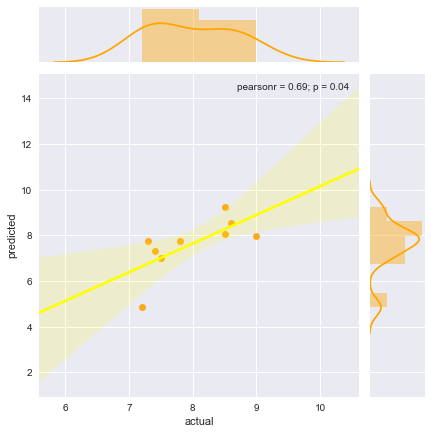

In [82]:
cluster_plot(0, df_bestclusters)

## 3. Customer input

Get customer (user) data from their Spotify most-played tracks. Use this data to find most compatible critic(s). 

User's averaged weighted music features are based on their most-played tracks, rather than albums they've rated. Several reasons for this difference:
- Asking users to rate albums on the spot is time-consuming and subjective - likely that a user's ratings will change with each use-case of the recommendation engine.
- Most-played tracks have the same audio features as album features
- Grabbing for example, the top 50 most-played tracks, is more likely to introduce similar diversity to the user's rating repertoire as a Pitchfork critic rating multiple albums

### 3.1 Get user's top tracks/Spotify features

We grab the top 50 most-played tracks from the "medium-term" time range. The number of tracks can be changed with the `limit` parameter, and the time range can be changed with `ranges` parameter. Here, I use my username, but anyone can use their usename and login to produce the same analysis.

Then we compile Spotify's audio feature analysis for each track.

In [87]:
import pprint
import sys
import spotipy
import spotipy.util as util

from spotipy.oauth2 import SpotifyClientCredentials
from pandas.io.json import json_normalize

myClientId = '7394642bcfbf471fbf4004e64cdeffce'
mySecret = '488067b779174b7ca884d1c9ce0c51e6'
myRedirect = 'http://localhost:8888/callback' # usually 'http://localhost:8888/callback'
username = 'pinkishpanda'
limit = 50 # number of tracks for Spotify to return

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

scope = 'user-top-read'
token = util.prompt_for_user_token(username, scope, myClientId, mySecret, myRedirect)

if token:
    sp = spotipy.Spotify(auth=token)
    sp.trace = False
    #ranges = ['short_term', 'medium_term', 'long_term']
    ranges = ['medium_term'] # time range for top tracks
    for range in ranges:
        print("range:", range)
        results = sp.current_user_top_tracks(time_range=range, limit=limit)
        for i, item in enumerate(results['items']):
            print( i, item['name'], '//', item['artists'][0]['name'])
        print
        
else:
    print("Can't get token for", username)

results = pd.DataFrame(results['items'])

range: medium_term
0 Liebestraume No. 3 In A-flat Major (Nottorno No. 3) // Jean-Yves Thibaudet
1 Truant // Burial
2 Hyper Object // Blank Banshee
3 Teen Pregnancy // Blank Banshee
4 The Low Places // Jon Hopkins
5 Une Barque Sur L'océan from Miroirs // André Laplante
6 passionfruit // yaeji
7 Meteor // the bird and the bee
8 Futile Devices (Doveman Remix) // Sufjan Stevens
9 Mystery of Love // Sufjan Stevens
10 Love Is Stronger Than Pride // Amber Mark
11 Drifting Away // biosphere
12 Deep Space // Blank Banshee
13 Panacea // Disasterpeace
14 My Machine // Blank Banshee
15 Wheel // Visible Cloaks
16 Shadow // Chromatics
17 On & On // Cartoon
18 My Love // the bird and the bee
19 B:/ Start Up // Blank Banshee
20 Neon Pattern Drum // Jon Hopkins
21 C O S M // Jon Hopkins
22 M.A.Y. In the Backyard // Ryuichi Sakamoto
23 Nine // Autechre
24 Mine // Bazzi
25 Oh my my // Smerz
26 Germination // Ryuichi Sakamoto
27 Guap // yaeji
28 Pause // Harris Cole
29 Warm In The Winter // Glass Candy
30

#### Extract Spotify information

In [88]:
name = []
a_id = []
artist = []
t_id = []

for index, row in results.iterrows():
    
    album_name = row['album']['name'] # album info
    album_id = row['album']['id'] # album spotify id
    album_artist = row['artists'][0]['name'] # album artist
    track_id = row['id'] # track id
    
    name.append(album_name)
    a_id.append(album_id)
    artist.append(album_artist)
    t_id.append(track_id)

df_spotify = pd.DataFrame({'track_name':name, 'album_id':a_id, 'artist':artist, 'track_id':t_id})
df_spotify.head()

,album_id,artist,track_id,track_name
0,3fZN1IFpMZNcCGCNrOaaZO,Jean-Yves Thibaudet,05LgxpgKQtdeTMEqNYqmt7,Piano Essentials
1,7c1cUV8hKqGC255WWoHYIc,Burial,7w3JgjdUZiptt3RgMevwmR,Truant
2,5AcOa8jiTLbwlBaIIbCjYn,Blank Banshee,60goI1iHOBGESUj7xcwOKs,Blank Banshee 0
3,5AcOa8jiTLbwlBaIIbCjYn,Blank Banshee,4Jgdb4akerysh6y9SJVSF0,Blank Banshee 0
4,5f4LV7TuJs1aHH6VWbnULx,Jon Hopkins,4R9Am4C0S0eylcwbnLG6zj,Insides


#### Get audio feature analysis for each track

Since we are dealing with tracks, not albums, there is no need to average features per album - we conduct Spotify audio feature analysis per track.

In [89]:
track_features = sp.audio_features(t_id)

df_trackfeat = pd.DataFrame(track_features)
df_trackfeat.head()

,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,0.988,https://api.spotify.com/v1/audio-analysis/05Lg...,0.230,246520,0.0465,05LgxpgKQtdeTMEqNYqmt7,0.891,8,0.109,-21.616,1,0.0453,72.163,3,https://api.spotify.com/v1/tracks/05LgxpgKQtde...,audio_features,spotify:track:05LgxpgKQtdeTMEqNYqmt7,0.0344
1,0.227,https://api.spotify.com/v1/audio-analysis/7w3J...,0.667,705362,0.5410,7w3JgjdUZiptt3RgMevwmR,0.825,8,0.394,-13.801,0,0.1140,120.945,4,https://api.spotify.com/v1/tracks/7w3JgjdUZipt...,audio_features,spotify:track:7w3JgjdUZiptt3RgMevwmR,0.2240
2,0.163,https://api.spotify.com/v1/audio-analysis/60go...,0.745,165000,0.9600,60goI1iHOBGESUj7xcwOKs,0.363,10,0.312,-5.284,0,0.2190,96.017,4,https://api.spotify.com/v1/tracks/60goI1iHOBGE...,audio_features,spotify:track:60goI1iHOBGESUj7xcwOKs,0.7830
3,0.295,https://api.spotify.com/v1/audio-analysis/4Jgd...,0.750,177297,0.9840,4Jgdb4akerysh6y9SJVSF0,0.373,7,0.163,-4.933,0,0.0780,111.002,4,https://api.spotify.com/v1/tracks/4Jgdb4akerys...,audio_features,spotify:track:4Jgdb4akerysh6y9SJVSF0,0.7670
4,0.563,https://api.spotify.com/v1/audio-analysis/4R9A...,0.731,394587,0.3930,4R9Am4C0S0eylcwbnLG6zj,0.919,9,0.193,-13.855,1,0.0591,152.015,4,https://api.spotify.com/v1/tracks/4R9Am4C0S0ey...,audio_features,spotify:track:4R9Am4C0S0eylcwbnLG6zj,0.2430


#### Average features of user's 'most-played' tracks.
- <b><i>All music is a "10.0" problem.</i></b> Scaling user's most-played tracks is tricky - all of their top-played tracks can be regarded as them endorsing a high album rating. Thus, scaling becomes inaccurate as there is no range of user "album ratings" between 0 and 10 (or relatively 0 to 1) and lower-ranking but top-played tracks would be regarded as a "0" rating. 

- <b><i>Method</i></b>. Thus, our weighting method here differs from what we used for critics. Instead, to take an average of each feature for the user's most-played tracks, we weigh tracks' features by its ranking - less weight is given to lower ranking (less-played) tracks. See code comments below more for details on how this average + weighting is conducted.

In [90]:
# make weights
weights = np.linspace(0.02, 1, num=limit) # evenly spaced weights, 0-1; total # = track limit given to Spotify query
weights = np.flip(weights, axis=0) # change to descending order

# select features
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 
                'liveness', 'loudness', 'speechiness', 'tempo', 'mode',
                'valence']

# dataframe of unweighted features
df_trackfeat_matrix = df_trackfeat[features]

# average weighted features
weighted_average = df_trackfeat_matrix.multiply(weights, axis=0).sum()*10 / (len(df_trackfeat_matrix)/2)
print('Weighted averages (by feature):\n')
print(weighted_average)

Weighted averages (by feature):

acousticness           5.0113064000
danceability           5.8855440000
energy                 4.7714840800
instrumentalness       5.2118259602
liveness               1.7625528000
loudness            -132.5014400000
speechiness            0.8942832000
tempo               1223.5785360000
mode                   5.6160000000
valence                3.3422808000
dtype: float64


### 3.2 Find compatible critics

In [91]:
# Import table of unweighted features, where each row represents an album review
df_features_unweighted = pd.read_pickle('df_features_unweighted.pkl')

# Replace NaN's with that column's (feature's) mean
df_features_unweighted = df_features_unweighted.fillna(df_features_unweighted.mean())
df_features_unweighted.head()

df_critics = pd.DataFrame()
for index, row in df_authors_reviews.iterrows():
    
    reviews = row['reviews']
    author = row['author_fullname']   

    # dataframe of each of the author's reviews - with features as columns
    df_author = None
    for r_id in reviews:
        if df_author is None: # initialize dataframe
            df_author = df_features_unweighted[df_features_unweighted['reviewid']==r_id]
        else:
            df_author = df_author.append(pd.DataFrame(df_features_unweighted[df_features_unweighted['reviewid']==r_id]))
    
    # average rating-weighted features
    df_author_scored = df_author.multiply(df_author['score'], axis=0) # weigh 
    author_average = df_author_scored.mean()
    author_average = pd.DataFrame(author_average[features]) # narrow results to only include desired features
    author_average = author_average.T # transpose dataframe so columns = features

    if df_critics.empty: # initialize dataframe 
        df_critics = author_average
    else:
        df_critics = pd.concat([df_critics, author_average])

df_critics = df_critics.set_index(df_authors_reviews['author_fullname'])
df_critics = df_critics[np.isfinite(df_critics['acousticness'])] # remove critics with NaN's for all features
df_critics.head()

,acousticness,danceability,energy,instrumentalness,liveness,loudness,speechiness,tempo,mode,valence
author_fullname,,,,,,,,,,
aaron leitko,1.7594581609,2.7159847524,4.7725593725,3.5497721884,1.5613704865,-63.7227510339,0.4525997495,886.1482191559,5.1194929396,2.6455534413
abigail covington,1.4887642381,4.2488738095,4.3485176190,0.0604087799,1.5928822857,-49.4278514286,1.4970022857,796.1423652381,3.6304761905,3.4550247619
abigail garnett,1.1304812294,4.7073270729,4.8486280447,4.5853091521,1.0007576990,-68.4537011869,0.4191513606,865.7710367352,4.3652669553,3.5172242637
adam dlugacz,0.0012151585,2.0760923077,5.2881230769,0.4156654175,2.2185692308,-29.0526923077,0.3181984615,866.0377384615,4.8461538462,2.4090230769
adam moerder,1.2544909304,2.7719384450,4.2067558045,1.5077573062,1.2092718899,-45.4294274212,0.4058357429,771.6143559536,4.1454142274,2.6612617485


#### Calculate distance from user and critics' features (similarity)

1. From each critic in our table, we take the difference between their average features and the user's to effectively make a matrix of differences, where index = critic and column = (critic averaged feature) - (user averaged features).
2. Then, for each feature column we scale these values (differences) to avoid larger differences for larger-scaled features distorting our distance metric.
3. For each critic, we average their difference values.
4. Take the critic with the least difference from user as the first-choice critic.
5. Identify this critic's cluster and include as second-choice critics.

In [92]:
from sklearn import preprocessing

# 1. Make difference matrix

df_difference = pd.DataFrame.copy(df_critics)

for feature in df_critics.columns:
    
    df_difference[feature] = abs(df_critics[feature] - weighted_average[feature]) # absolute value of features
    
    # 2. Scale features
    
    min_max_scaler = preprocessing.MinMaxScaler()
    df_difference[feature] = min_max_scaler.fit_transform(df_difference[feature].values.reshape(-1, 1)) 

# 3. Average each critic's feature differences from user's
average_difference = df_difference.mean(axis=1)

# 4. Take least-different critic ('best critic')
best_critic = average_difference.idxmin()

# 5. Find best critic's cluster

for idx, row in df_bestclusters.iterrows():
    authors = row['author']
    if best_critic in authors:
        best_cluster = row
    else:
        continue

best_cluster['author']
second_best = [a for a in best_cluster['author'] if a != best_critic]

#### Print results!

In [93]:
print('Your top match is:', best_critic)
print('Your other matches are:', second_best)

Your top match is: barry walters
Your other matches are: ['jesse jarnow', 'jonathan bernstein', 'stephen erlewine', 'michael agovino', 'rohan samarth', 'john everhart', 'stephen duesner', 'stephen may', 'philip shelley', 'christopher drabick', 'daniel crumb']
